In [1]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#from karateclub import Node2Vec
from src.helper import draw_spring, load_graph_from_json, dataframe_from_results
np.random.seed(123)

# 4 Community Detection

The detection of communities is crucial for drawing insights from networks. Networks can be highly complex, often spanning hundreds, thousands, or even millions of node. Grouping (clustering) nodes together is one way to identify possible patterns. Clusters may be consist of social actors that are more closely tied and interact more frequently than the rest of the network (and then perhaps literally communities), they may reveal similarities in meaning, or clusters can indicate how precedents relate.

For example, if one looks at a case citation or case similarity netowrk of 200,000 nodes, it would be a gain if one could group that complexity into, say, 8 communities. These communities might show a common similarity between these cases, for example that they focus on causality, the right to a fair trial, apologies, whistleblower cases, traffic accidents, etc. These communites might also point towards the case law's genealogy in terms of precedents. Combined with centrality measures, community detection allows zooming in on specific clusters, identifying central cases within clusters of decisions in addition to the network as a whole, to find communities within communities, or to analyze over time which groups of nodes were clustered when (or were no longer clustered).

Sometimes communities will be visible to the naked eye, as we can see here with an example of the barbell graph. This is a form of graph that two obvious communities in the "plates" of the barbell joined together by a number of nodes (in the case below 3) that form the metal shaft.

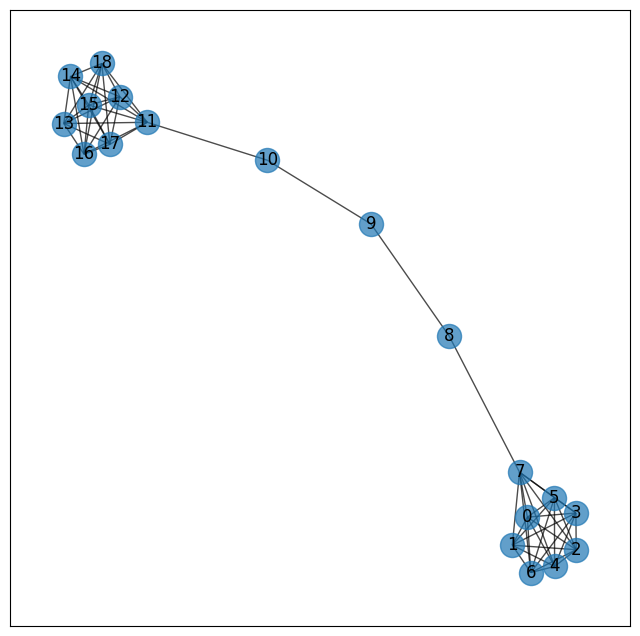

In [2]:
g_barbell = nx.barbell_graph(8, 3)
draw_spring(g_barbell)

It should be obvious at this point that in most scenarios it will not be possible to detect communities just by looking. Networks are often too complex. Community detection methods can assist in unraveling the complexity.

We explore the approach of network algorithms. Network algorithms rely on the existing graph and its properties to find clusters. (An alternative would be to use machine-learning algorithms, such as KMeans clustering, which use the properties of the nodes. We do not discuss those algorithms here.) Below, we present two network algorithms: the Girvan-Newman algorithm and Louvain Communities. Other algorithms exist, but are not covered in this work.

## 4.1 Girvan-Newman

The Girvan-Newman method for partitioning of communities (Girvan and Newman, 2002) depends on the edge-betweenness property. We have covered node-betweenness in Chapter 3. Node-betweennes measures how many shortest paths between nodes $v$ and $w$ pass through a given node $n$. Edge-betweenness measures the same property, but for edges instead of nodes. 

We can calculate edge-betweenness using the edge_betweenness_centrality function in NetworkX. This will provide a list of all the edges present in the network with their centrality score, as we can see below:

In [5]:
g_karate = nx.karate_club_graph()
edges = nx.edge_betweenness_centrality(g_karate).keys()
scores = nx.edge_betweenness_centrality(g_karate).values()
pd.DataFrame({"edges":edges, "scores":scores}).sort_values("scores", ascending=False).set_index("edges")

,scores
edges,
"(0, 31)",0.127260
"(0, 6)",0.078134
"(0, 5)",0.078134
"(0, 2)",0.077788
"(0, 8)",0.074240
...,...
"(26, 29)",0.004533
"(24, 25)",0.004219
"(3, 7)",0.003366


The Girvan Newman algorithm progressively removes the edge with the highest betweenness centrality score. This will progressively break down the graph, creating distinct communities. In every new iteration in the process, the betweenness centrality for edges is recalculated. This means that the calculation becomes progressively easier as more and more edges are removed.

In NetworkX this is impemented as an iterator, which can be run multiple times using the next() function, each time removing one more edge. The iterator will return the connected components of the graph as long as there is a reduction in the number of connected components. 

The results are shown below:

In [8]:
gn_iterator = nx.algorithms.community.girvan_newman(g_karate)

gn_communities = []
for i in range(0,5):
    temp = next(gn_iterator)
    print(f"iteration {i} with {i+2} connected components")
    print(temp)
    print("\n")
    gn_communities.append(temp)

iteration 0 with 2 connected components
({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})


iteration 1 with 3 connected components
({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9})


iteration 2 with 4 connected components
({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9})


iteration 3 with 5 connected components
({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9})


iteration 4 with 6 connected components
({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11})




Taking the first bisection of the graph at iteration 0 will yield reasonable results:

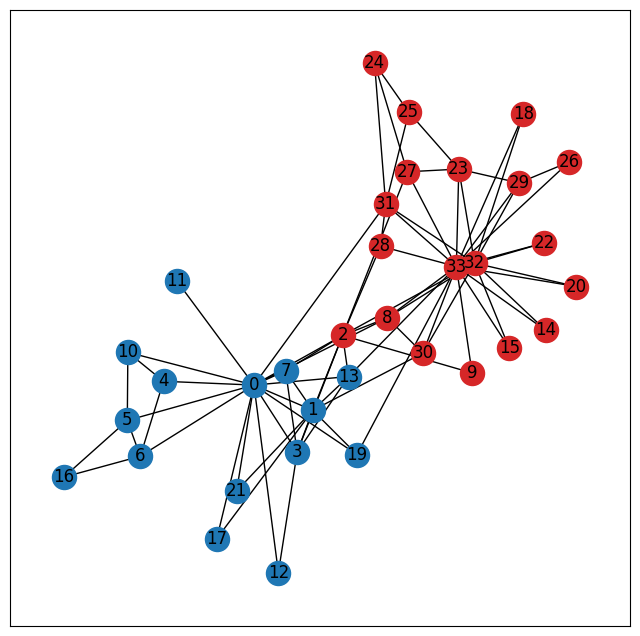

In [9]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[0][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[0][1]), node_color="tab:red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

Now we plot the division that we obtain if we allow the algorithm to go through 3 iterations, removing enough edges to have 4 distinct connected components.

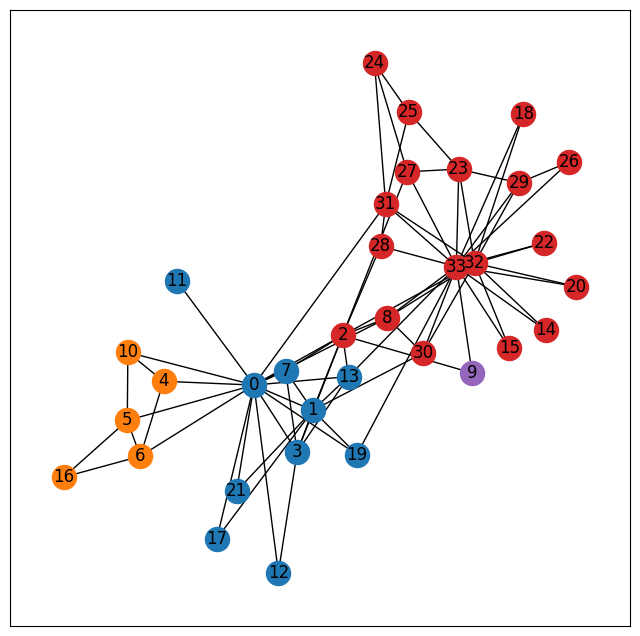

In [10]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][1]), node_color="tab:red")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][2]), node_color="tab:orange")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][3]), node_color="tab:purple")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

Domain expertise is required to determine whether the communities are substantively meaningful.

## 4.2 Louvain Communities

The Louvain method for community detection (Blondel, Lambiotte & Lefebvre 2008) is an algorithm that finds communities by using the concept of modularity gain. 

In order to fully introduce this method, we first have to understand the concept of modularity.

### Modularity

Modularity, in essence, compares the edges of nodes in a certain community to the edges the nodes have to nodes outside of the community. For example, it may be the case that court decisions on contract law are more likely to cite one another (edges to nodes within the community) than to cite court decisions on another subject (edges to nodes outside the community). The higher the number of edges within the community relative to the edges to nodes outside of the community, the higher the community's modularity.


The formula for modularity can be presented in a variety of ways and there are advantages to each form or presentation. Here are two formulas (the formulas have been adapted from the documentation to make the notation easier to follow, especially for an attempt to put them in practice by hand):

$$ Q = \frac{1}{2m}\sum_{c=1}^{n} \left[ \Sigma A_c - \gamma\frac{\Sigma D_c^2}{2m} \right] $$


$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$


For our discussion we will focus on the second formula, because it most clearly shows a difference between two ratios. The representation we choose here provides the most insight into what modularity does. 

The formula essentially compared two proportions (fractions):

* $ \frac{\Sigma A_c}{2m} $ represents the proportion of purely intra-community edges for a given community to the total number of edges. (The division by 2 considers the fact that the adjacency matrix will count two for every edge.)

* $ \left( \frac{\Sigma D_c}{2m} \right) ^2 $ represents the proportion of the edges that a community has to nodes within and outside of itself to the total number of edges in the network.

The logic of this is that if the left hand side of the difference is greater than the right hand side of the difference one will get a positive number. And the larger the difference, the tighter a community is, the larger the number. Or, simply put, the more edges within the community relative to the number of edges to nodes outside of the community, the tighther the community.

For those interested in the mathematical underpinning of the formula, we provide a more specific breakdown of the formula below: 
* $ \Sigma A_c $ is the sum of the adjacency matrix of the community only (i.e., no edges to nodes outside of the community) .

* $ m $ is the total number of edges of the network.

* $\Sigma D_c$ is the degree of the nodes of the community, taking into consideration their edges to nodes outside of the community.

* $\gamma$ is a dampening parameter, that for our purposes can be ignored if set to 1. Making this number smaller will make it easier to find communities, and making it larger makes communities harder to find. (!!CHECK!!)

* The $ \Sigma $ is a summation notation that states that the difference between fractions will be repeated for every hypothesized community and added up. The higher the ultimate summation, the better the community partition is.

We can operationalize the formula 'by hand' on the graph of Florentine families hypothesizing that the families Castellani, Peruzzi and Strozzi form a community vis-a-vis the rest of the other families. A quick look at the graphs suggest that this is a reasonable grouping.

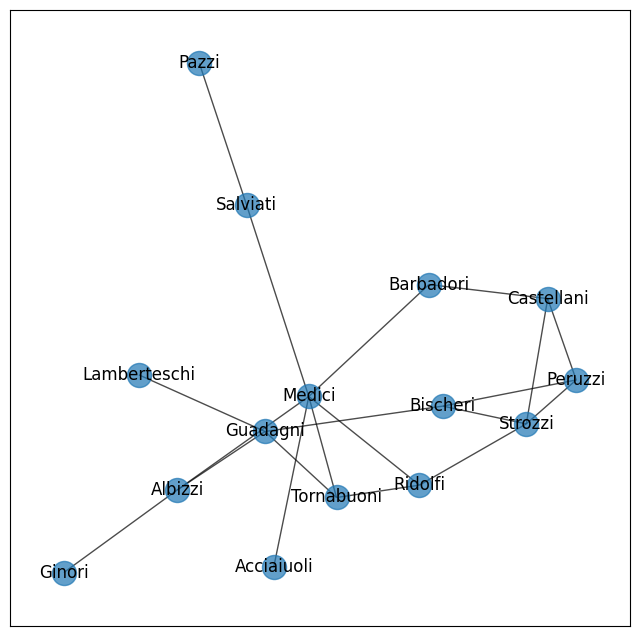

In [11]:
g_florentine = nx.florentine_families_graph()
draw_spring(g_florentine)

We first save two lists with the names of the nodes that we want to use as hypothesized communities. Castellani, Peruzzi and Strozzi in one list, the rest on the other.

In [12]:
fl_CPS = ['Castellani','Peruzzi','Strozzi']
fl_other= ['Acciaiuoli', 'Medici', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi']

Since m is just the number of edges we can obtain the number in this manner.

In [13]:
m = len(g_florentine.edges)
m

20

For $\Sigma A_c $ we need to get the adjacency matrix of just the nodes within the community. This means we need to sever the connection of the community with other nodes. We can get this with the subgraph function.

In [14]:
sub_fl_CPS = g_florentine.subgraph(fl_CPS)
sub_fl_other = g_florentine.subgraph(fl_other)

Now we can get the adjacency matrix of the subgraphs like this...

In [15]:
nx.adjacency_matrix(sub_fl_CPS).todense()

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

Numpy can sum all the values of such matrices with a call to np.sum.

In [16]:
SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())
print(f"the value of SigmaA_c for the CPS community is {SA_cps} and for the other is {SA_other}")

the value of SigmaA_c for the CPS community is 6 and for the other is 26


This provides us with the information we need for the left hand side of the difference.

Now we move to work on the right side of the difference. The value of $ \Sigma D_c $ is the sum of the degree of the nodes that interest us, but not with their values cut off from the network - that is, not as subgraphs - but in their full values connected to the Florentine families network. 

In terms of code it can be slightly tricky to unpack these values. Below we use a np.sum over a list comprehension that produces the degree scores of only the nodes we need.

In [17]:
SD_cps = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_CPS))])

SD_other = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_other))])

print(f"the value of SigmaD_c for the CPS community is {SD_cps} and for the other is {SD_other}")

the value of SigmaD_c for the CPS community is 10 and for the other is 30


Now we are ready to fill in the blanks. Remember the formula is:

$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

So for the first community we have

$$ CPS =\left[ \frac{6}{40} - \gamma\left( \frac{10}{40} \right) ^2 \right] = 0.875 $$

In [18]:
CPS_result = (SA_cps/(2*m)) - ((SD_cps/(2*m))**2)
CPS_result

0.0875

And for the second 

$$ other = \left[ \frac{26}{40} - \gamma\left( \frac{30}{40} \right) ^2 \right] = 0.875 $$

In [19]:
other_result = (SA_other/(2*m)) - ((SD_other/(2*m))**2)
other_result

0.08750000000000002

And adding them together we get 0.175

In [20]:
CPS_result + other_result

0.17500000000000002

 Which is the same as the official result.

In [21]:
nx.algorithms.community.modularity(g_florentine, [fl_CPS, fl_other])

0.17500000000000002

Thus the following partition has the positive modularity score of 0.175.

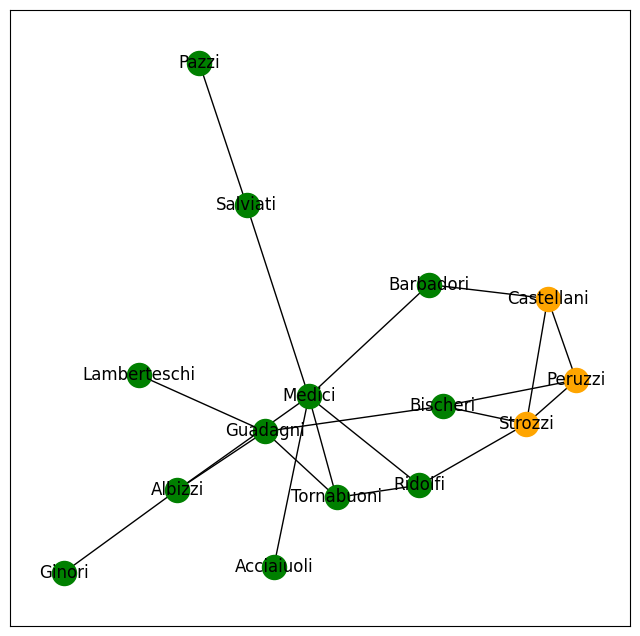

In [22]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_CPS, node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_other, node_color='green')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

### The Louvain Communities Algorithm

The Louvain community detection aims to find the distribution of communities that will give the highest modularity score, using a cumulative random search:

1. It will asume every node is a community and score the modularity.
2. It will assign every node to a community with one of its neighbors and score the modularity of the result.
3. It will keep the assignment that gives the highest modularity score.
4. The resulting communities will be treated as nodes.
5. Step 1 is repeated.

This process keeps going until there is no more modularity gain.

We can quickly try to run the Louvain communities algorithm to find the best partition of the Florentine families network that we used earlier to discuss modularity.
It turns out the best split is in four communities. Compared to our intuitive results presented above, we can see that Castellani, Peruzzi and Strozzi did deserve to go together, but that Bischeri should have been also part their team.

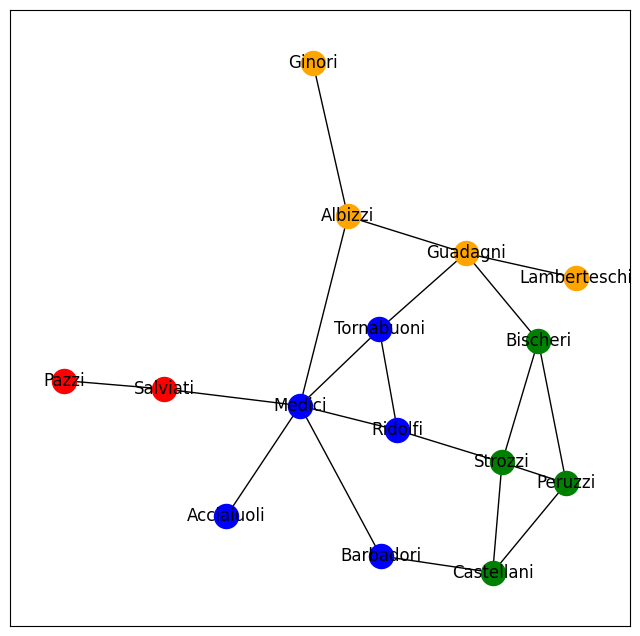

In [23]:
plt.figure(figsize=(8,8))
result = nx.algorithms.community.louvain_communities(g_florentine)
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[0], node_color='blue')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[1], node_color='red')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[2], node_color='green')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[3], node_color='orange')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

When calculating the modularity score for the Louvain-detected communities, we can observe that at 0.3975 quite higher than our initial partition.

In [24]:
nx.algorithms.community.modularity(g_florentine, result)

0.39749999999999996

We now try to approximate this by hand. Let us see how far we can get. We will use a smaller graph, the kite, to make our life easier. There are key differences between what we are doing and the actual Louvain Communities algorithm. However, this will be enough for us to get an idea of what is going on.

The question is how to best partition the kite in terms of modularity.

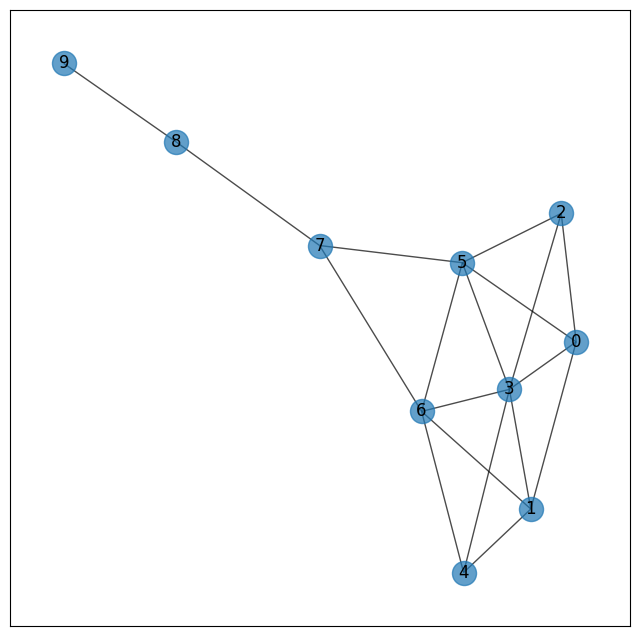

In [25]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite)

Doing a pseudo-Louvain process, We begin by assigning each node in the kite graph to its own community. Since this is a very bad partition, it makes sense that we get a negative modularity score.

In [26]:
nx.algorithms.community.modularity(g_kite, [[x] for x in range(0,10)])

-0.11574074074074076

Now we will assign each node, to one of its neighbors, and obtain the modularity score.

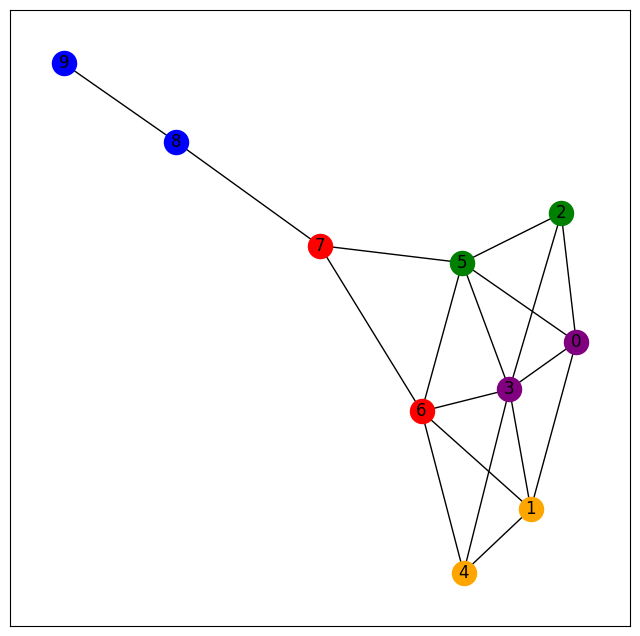

In [27]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[7,6], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,2], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[3,0], node_color='purple')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [28]:
nx.algorithms.community.modularity(g_kite, [[9,8], [7,6], [5,2],[4,1],[3,0]])

0.057098765432098755

Then we could keep assigning nodes and see an increase.

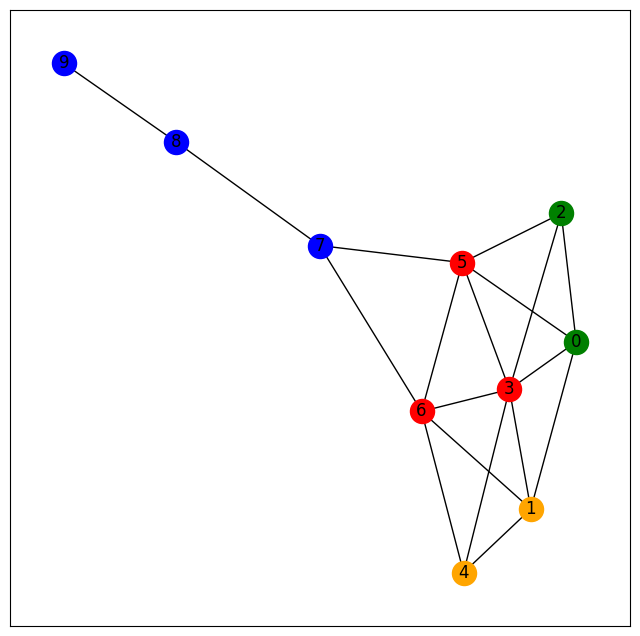

In [29]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[6,5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [30]:
nx.algorithms.community.modularity(g_kite, [[9,8,7], [6,5,3], [2,0],[4,1]])

0.08796296296296295

But not every reassignment is going to be an increase. If we extend the first cluster, we will get a decrease in modularity.

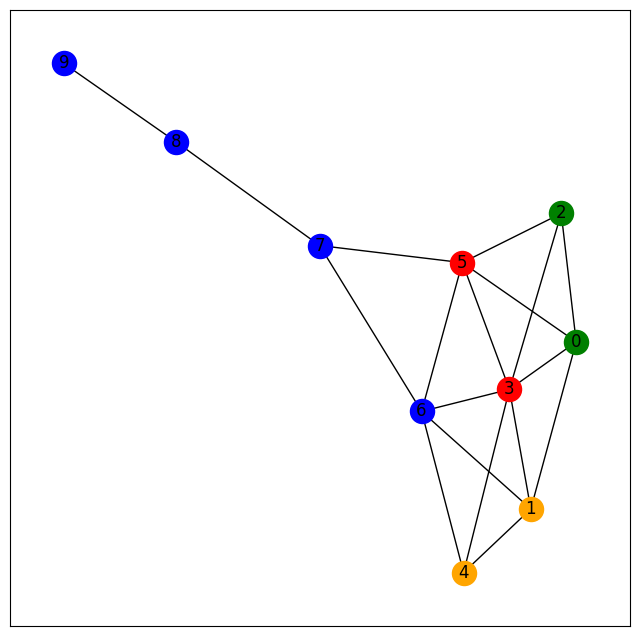

In [31]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7, 6], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [101]:
nx.algorithms.community.modularity(g_kite, [[9,8,7, 6], [5,3], [2,0],[4,1]])

0.07098765432098764

Our pseudo-Louvain algorithm would therefore stop short of that last assignment. The real Louvain method would do this in an mechanical, incremental fashion until the communities with very good modularity scores are found. The algorithm has elements of randomness, so it is not guaranteed to achieve the best result, or the same result every time it is run.

A difference of note is that instead of incrementally linking up the nodes of the kite, what are the communities at the first level will be turned into nodes at the second level. (!!add photo from louvain to leuven article!!). 

What this means in practice, is that unlike what we are doing, the algorithm does not focus on modularity per se, but on modularity gain. That is, it focuses on the difference in modularity between one partitioning and another. It does not really look for the highest modularity value, but instead keeps going while it finds positive modularity gain, or until modularity gains are so small that they fall below a specified margin.

Happily, the formula for modularity gain is not so different from that of modularity

$$ \Delta Q = \left[ \frac{\Sigma A_c + K_{in}}{2m} - \frac{\Sigma D_c + K_{in}}{2m} \right] - \left[\frac{\Sigma A_c}{2m}-\frac{\Sigma D_c}{2m} - \frac{K_in}{2m}  \right]   $$

In fact, it is the ratio of two modulary scores. One (the left brackets) is the score with the node $K$ inserted into it and the the other (the right bracket) is the score with the node $K$ removed from it. It is added on the left and removed on the right to represent the delta, or the difference in modularity, when one community gains a node and another one loses it.

With our pseudo-Louvain approach we did not did do the best possible combination, but with the real Louvain communities algorithm we can see what the better partition would be:

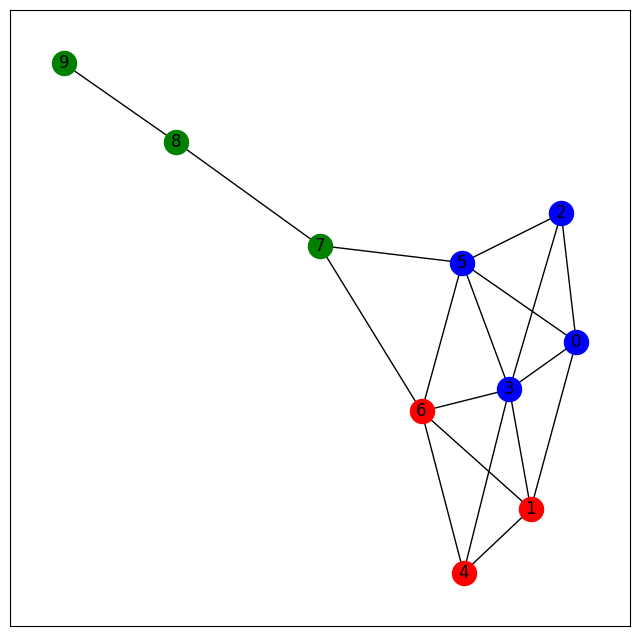

In [32]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
result = nx.algorithms.community.louvain_communities(g_kite)
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[0], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[1], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[2], node_color='green')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

We can do the same for the subgraph of the CJEU case law example. We first calculate the number of communities:

In [33]:
g_consprot2 = load_graph_from_json("data/g_consprot2.json")
communities = sorted(nx.algorithms.community.greedy_modularity_communities(g_consprot2), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")

The network has 13 communities.


We subsequently plot assign each node to a community and visualize the communities in the network.

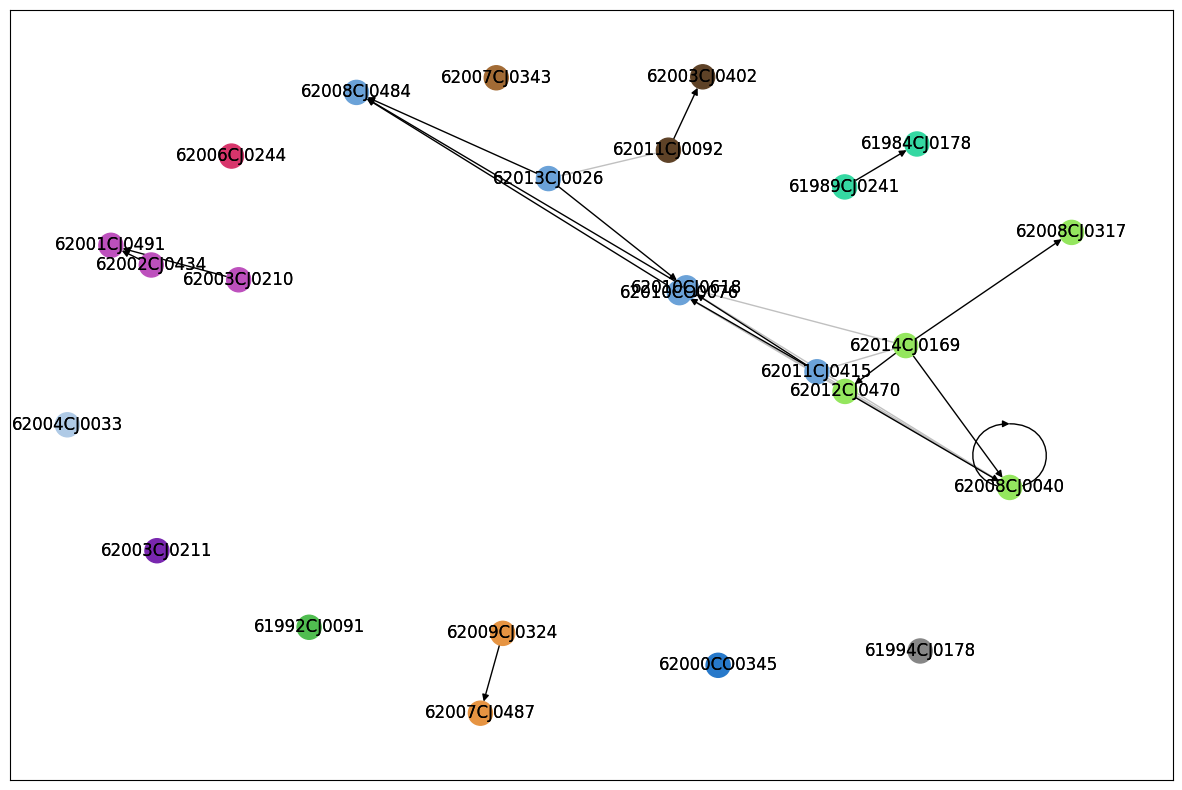

In [34]:

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

g_consprot2_pos = nx.spring_layout(g_consprot2)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)
plt.show()

## 4.3 Centrality of communities

Once a community has been found, it is possible to submit that community to forms of analysis that were first applied to the whole graph. Naturally results will change when we only consider the smaller community.

In NetworkX this is done using the ````subgraph```` function, passing in the node list of the selected community. 

Here we will consider the community that centers around the President of the Karate Club which appears in red below.

In [41]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_1), node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_2), node_color="red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

NameError: name 'X' is not defined

If we see the closeness centrality scores, we find that the top performers include naturally the President at node 0, the Karate instructor who is node 33 and node 13 does pretty well being in the 5th spot.

In [43]:
karate_closeness = pd.DataFrame({"nodes":nx.closeness_centrality(g_karate).keys(), "centrality":nx.closeness_centrality(g_karate).values()})\
.sort_values("centrality", ascending=False)\
.head(10)
karate_closeness


,nodes,centrality
0,0,0.568966
2,2,0.559322
33,33,0.550000
31,31,0.540984
13,13,0.515625
32,32,0.515625
8,8,0.515625
19,19,0.500000
1,1,0.485294
3,3,0.464789


However, if we consider only the subgraph of the supporters of the President, the network metrics change, including the centrality ranking.

In [44]:
g_subkarate = nx.subgraph(g_karate, nodes_cluster_2)
draw_spring(g_subkarate)

NameError: name 'nodes_cluster_2' is not defined

In [111]:
pd.DataFrame({"nodes":nx.closeness_centrality(g_subkarate).keys(), "centrality":nx.closeness_centrality(g_subkarate).values()})\
.sort_values("centrality", ascending=False)\
.head(10)

,nodes,centrality
0,0,0.933333
1,1,0.636364
2,3,0.583333
4,5,0.583333
5,6,0.583333
3,4,0.560000
7,10,0.560000
6,7,0.538462
10,13,0.538462
9,12,0.518519


Node 13 is no longer as important now that his friends with the faction of the instructor are factored out. In contrast, node 1 rises in prominence from position 9 to second place.

This analysis is only schematic but it shows that identifying communities can be an important step for getting more finely grained network metrics.